# Bank Credit Risk Classification
By : [enricoroselino](https://www.linkedin.com/in/enricoroselino/)

Dataset : [ID/X Partners Virtual Intern Bank Loan Dataset]()

Objective : 
* Build a model that can **predict credit risk** using a dataset provided by the company consisting of **accepted and rejected data on loans**

Problem :
* there is no target column

Theoretical Basis :

**Bad credit** refers to an **individual's history of poor payment of bills and loans,** and the likelihood that he/she will not honor financial obligations in the future. A borrower with bad credit will find it **difficult to get their loan approved** because they are considered a credit risk. 
* Late payments : If you have delayed making payments for more than a month
* Charge-offs : If an account has become delinquent for too long
* Defaulting on loans : same as charge-offs, missed more than one payment and have not paid at the end of the month, the account is marked as in default.

[Corporate Finance Institute](https://corporatefinanceinstitute.com/resources/knowledge/credit/bad-credit-causes/)

**Being late by more than one month is considered delinquent**, However, delinquency is **not generally reported** to the major credit bureaus **until two consecutive monthly payments have been missed**. Delinquent accounts on a credit report can lower credit scores and reduce an individual's ability to borrow in the future.

In fact, while making one minimum payment keeps delinquency from worsening, making two decreases delinquency. If you are 90 days delinquent, for instance, then paying the amount equal to two minimum payments will bring you to 60 days.
[Investopedia](https://www.investopedia.com/articles/pf/11/intro-to-credit-card-delinquency.asp)

* **Current** means The borrower is making **payments on time**.
* **Grace period** is a set number of days **after the due date** during which payment may be made by the borrower **without penalty**.
* **Late** means the borrower **failed to make** a timely **payment within the grace period**. 
* **Default** means the **loan agreement has been terminated by the lending company**, and the outstanding balance of the loan is due and payable

[Mintos](https://www.mintos.com/blog/everything-you-wanted-to-know-about-loan-lifecycle-and-status/)

Summary : Credit Risk is based on loan status and how consistent borrower is making payments on time

risk_label feature description :
* 0 : bad
* 1 : good
* 2 : excellent

Summary :

* It can be concluded that the **Random Forest Classifier** model is more reliable with **f1 score : 96.21%** on the test data compared to other models. The model is reliable because **fewer errors** predict credit risk which is **actually high risk and low risk**.

* As an alternative, **Deep Neural Network** model has **f1 score : 93.02%** on the test data.

In [93]:
import os
import math
import re
import pandas as pd
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from feature_engine.outliers import Winsorizer, OutlierTrimmer
from fast_ml.model_development import train_valid_test_split

from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [2]:
data_path = os.path.join("dataset", "loan_data_2007_2014.csv")
loan_df = pd.read_csv(data_path, low_memory=False, index_col=0)

In [3]:
# drop columns that filled with all NaN values
loan_df = loan_df.dropna(axis = 1, how = "all")
# drop duplicated data
loan_df = loan_df.drop_duplicates()
loan_df.shape

(466285, 57)

In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [5]:
loan_df = loan_df.drop(["id", "member_id"], axis=1)

In [6]:
check_missing = loan_df.isnull().sum() * 100 / loan_df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

mths_since_last_record         86.566585
mths_since_last_major_derog    78.773926
desc                           72.981546
mths_since_last_delinq         53.690554
next_pymnt_d                   48.728567
total_rev_hi_lim               15.071469
tot_cur_bal                    15.071469
tot_coll_amt                   15.071469
emp_title                       5.916553
emp_length                      4.505399
last_pymnt_d                    0.080637
revol_util                      0.072917
collections_12_mths_ex_med      0.031097
last_credit_pull_d              0.009007
inq_last_6mths                  0.006219
open_acc                        0.006219
total_acc                       0.006219
earliest_cr_line                0.006219
delinq_2yrs                     0.006219
acc_now_delinq                  0.006219
pub_rec                         0.006219
title                           0.004289
annual_inc                      0.000858
dtype: float64

In [7]:
col_names = check_missing[check_missing < 75].index.tolist()
for i in loan_df[col_names] :
    print(f"{i} : {loan_df[i].unique()}")

loan_amnt : [ 5000  2500  2400 ... 33675 27775 33175]
funded_amnt : [ 5000  2500  2400 ... 27775 33175 31725]
funded_amnt_inv : [ 4975.  2500.  2400. ... 30425. 33125. 33625.]
term : [' 36 months' ' 60 months']
int_rate : [10.65 15.27 15.96 13.49 12.69  7.9  18.64 21.28 14.65  9.91 16.29  6.03
 11.71 12.42 14.27 16.77  7.51  8.9  18.25  6.62 19.91 17.27 17.58 21.67
 19.42 22.06 20.89 20.3  23.91 19.03 23.52 23.13 22.74 22.35 24.11  6.
 22.11  7.49 11.99  5.99 10.99  9.99 18.79 11.49  8.49 15.99 16.49  6.99
 12.99 15.23 14.79  5.42 10.59 17.49 15.62 21.36 19.29 13.99 18.39 16.89
 17.99 20.62 20.99 22.85 19.69 20.25 23.22 21.74 22.48 23.59 12.62 18.07
 11.63  7.91  7.42 11.14 20.2  12.12 19.39 16.11 17.54 22.64 13.84 16.59
 17.19 12.87 20.69  9.67 21.82 19.79 18.49 22.94 24.59 24.4  21.48 14.82
 14.17  7.29 17.88 20.11 16.02 17.51 13.43 14.91 13.06 15.28 15.65 17.14
 11.11 10.37 16.4   7.66 10.   18.62 10.74  5.79  6.92  9.63 14.54 12.68
 19.36 13.8  18.99 21.59 20.85 21.22 19.74 20.48  

In [8]:
drop_cols = check_missing[check_missing >= 75].index.tolist() + [
                                                                "sub_grade",
                                                                "emp_title",
                                                                "url",
                                                                "desc",
                                                                "title",
                                                                "zip_code",
                                                                "policy_code",
                                                                "application_type",
                                                                "funded_amnt_inv",
                                                                "out_prncp_inv",
                                                                "total_pymnt_inv",
                                                                "total_pymnt_inv",
                                                                "addr_state"
                                                            ]
loan_df = loan_df.drop(drop_cols, axis=1)

In [9]:
loan_df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,...,0.00,Jan-15,171.62,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
1,2500,2500,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,...,1.11,Apr-13,119.66,NaN,Sep-13,0.0,0.0,NaN,NaN,NaN
2,2400,2400,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,...,0.00,Jun-14,649.91,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
3,10000,10000,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,...,0.00,Jan-15,357.48,NaN,Jan-15,0.0,0.0,NaN,NaN,NaN
4,3000,3000,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,...,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,0.0,NaN,NaN,NaN


### Define target

In [10]:
loan_df['loan_status'].value_counts(normalize=True)*100

Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: loan_status, dtype: float64

In [11]:
loan_df['loan_status'].isnull().sum()/len(loan_df)*100

0.0

In [12]:
loan_df['loan_status'] = loan_df['loan_status'].replace(
    {'Fully Paid':'excellent',
    'Current':'good',
    'In Grace Period':'good',
    'Late (16-30 days)':'bad',
    'Late (31-120 days)':'bad',
    'Charged Off': 'bad',
    'Default':'bad',
    'Does not meet the credit policy. Status:Charged Off':'bad',
    'Does not meet the credit policy. Status:Fully Paid': 'excellent'
})

In [13]:
loan_df['loan_status'].value_counts(normalize=True)*100

good         48.762452
excellent    40.045680
bad          11.191868
Name: loan_status, dtype: float64

### emp_length

In [14]:
loan_df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [15]:
loan_df['emp_length_int'] = loan_df['emp_length'].str.replace(r"\+ years|\ years|\ year", '', regex=True)
loan_df['emp_length_int'] = loan_df['emp_length_int'].str.replace('< 1', str(0))
loan_df['emp_length_int'] = loan_df['emp_length_int'].astype(float)

In [16]:
loan_df = loan_df.drop(["emp_length"], axis=1)

### term

In [17]:
loan_df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [18]:
loan_df['term'] = loan_df['term'].str.replace('\ months', '')
loan_df['term'] = loan_df['term'].str.replace(' ', '')

In [19]:
loan_df['term'].unique()

array(['36', '60'], dtype=object)

### earliest_cr_line

In [20]:
loan_df['earliest_cr_line'].head(3)

0    Jan-85
1    Apr-99
2    Nov-01
Name: earliest_cr_line, dtype: object

In [21]:
loan_df['earliest_cr_line_date'] = pd.to_datetime(loan_df['earliest_cr_line'], format='%b-%y')
loan_df['earliest_cr_line_date'].head(3)

0   1985-01-01
1   1999-04-01
2   2001-11-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

In [22]:
loan_df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
loan_df['mths_since_earliest_cr_line'].head(3)

0    395.0
1    224.0
2    193.0
Name: mths_since_earliest_cr_line, dtype: float64

In [23]:
loan_df['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [24]:
loan_df[loan_df['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(2)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0


In [25]:
loan_df.loc[loan_df['mths_since_earliest_cr_line']<0, 'mths_since_earliest_cr_line'] = loan_df['mths_since_earliest_cr_line'].max()

In [26]:
loan_df = loan_df.drop(['earliest_cr_line', 'earliest_cr_line_date'], axis=1)

### issue_d

In [27]:
loan_df['issue_d_date'] = pd.to_datetime(loan_df['issue_d'], format='%b-%y')
loan_df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['issue_d_date']) / np.timedelta64(1, 'M')))

In [28]:
loan_df['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

In [29]:
loan_df = loan_df.drop(['issue_d', 'issue_d_date'], axis=1)

### last_pymnt_d

In [30]:
loan_df['last_pymnt_d_date'] = pd.to_datetime(loan_df['last_pymnt_d'], format='%b-%y')
loan_df['mths_since_last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['last_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [31]:
loan_df['mths_since_last_pymnt_d'].describe()

count    465909.000000
mean         31.294369
std          12.809898
min          23.000000
25%          23.000000
50%          24.000000
75%          35.000000
max         120.000000
Name: mths_since_last_pymnt_d, dtype: float64

In [32]:
loan_df = loan_df.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1)

### next_pymnt_d

In [33]:
loan_df['next_pymnt_d_date'] = pd.to_datetime(loan_df['next_pymnt_d'], format='%b-%y')
loan_df['mths_since_next_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['next_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [34]:
loan_df['mths_since_next_pymnt_d'].describe()

count    239071.000000
mean         22.738136
std           6.082298
min          21.000000
25%          22.000000
50%          22.000000
75%          22.000000
max         120.000000
Name: mths_since_next_pymnt_d, dtype: float64

In [35]:
loan_df = loan_df.drop(['next_pymnt_d', 'next_pymnt_d_date'], axis=1)

### last_credit_pull_d

In [36]:
loan_df['last_credit_pull_d_date'] = pd.to_datetime(loan_df['last_credit_pull_d'], format='%b-%y')
loan_df['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['last_credit_pull_d_date']) / np.timedelta64(1, 'M')))

In [37]:
loan_df['mths_since_last_credit_pull_d'].describe()

count    466243.000000
mean         27.045588
std           9.636423
min          23.000000
25%          23.000000
50%          23.000000
75%          25.000000
max         127.000000
Name: mths_since_last_credit_pull_d, dtype: float64

In [38]:
loan_df = loan_df.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1)

### home_ownership

In [39]:
loan_df["home_ownership"].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [40]:
loan_df["home_ownership"] = loan_df["home_ownership"].replace({
    'ANY' : 'OTHER' 
})

In [41]:
loan_df["home_ownership"].value_counts(normalize=True)*100

MORTGAGE    50.586015
RENT        40.420129
OWN          8.943886
OTHER        0.039246
NONE         0.010723
Name: home_ownership, dtype: float64

## Data Visualization

In [42]:
loan_status_order = ["excellent", "good", "bad"]
grade_order = ["A", "B", "C", "D", "E", "F", "G"]

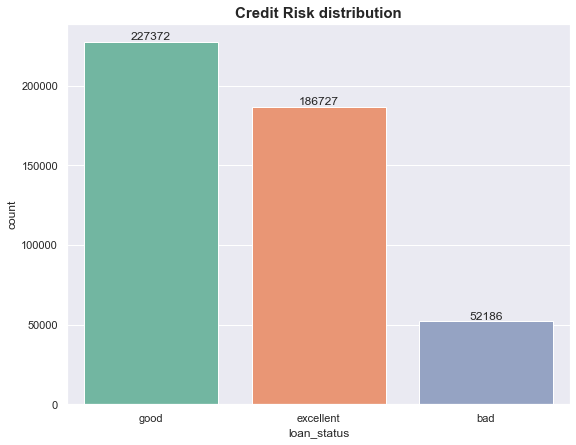

In [43]:
plt.figure(figsize=(9, 7))

abs_values = loan_df["loan_status"].value_counts(ascending=False).values
ax = sns.countplot(
    x= "loan_status",
    data= loan_df,
    order=loan_df["loan_status"].value_counts().index,
    palette='Set2'
)
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.title("Credit Risk distribution",
    loc="center",
    fontweight="bold",
    size=15
)
plt.show()

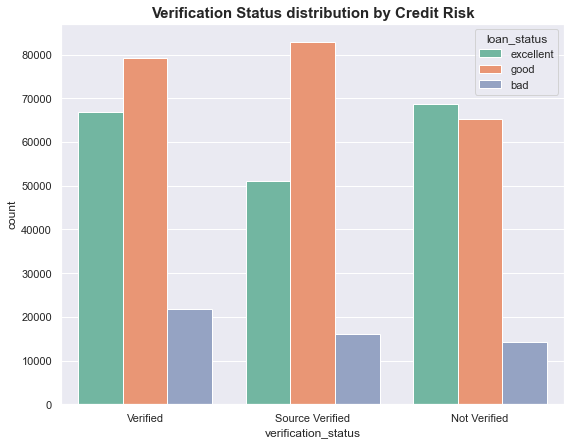

In [44]:
plt.figure(figsize=(9, 7))

sns.countplot(
    x= "verification_status",
    data= loan_df,
    hue = "loan_status",
    hue_order=loan_status_order,
    palette='Set2'
)
plt.title("Verification Status distribution by Credit Risk",
    loc="center",
    fontweight="bold",
    size=15
)
plt.show()

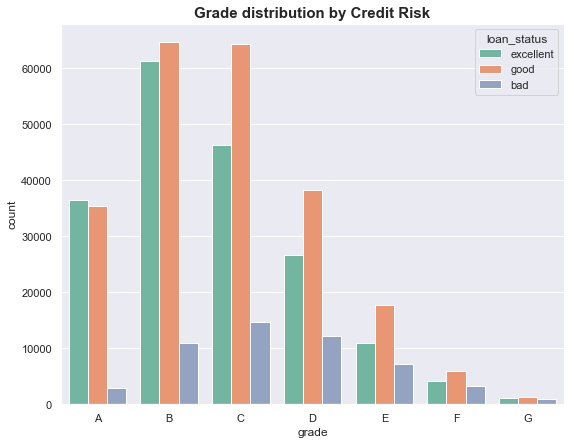

In [45]:
plt.figure(figsize=(9, 7))

sns.countplot(
    x= "grade",
    data= loan_df,
    hue = "loan_status",
    order=grade_order,
    hue_order=loan_status_order,
    palette='Set2'
)
plt.title("Grade distribution by Credit Risk",
    loc="center",
    fontweight="bold",
    size=15
)
plt.show()

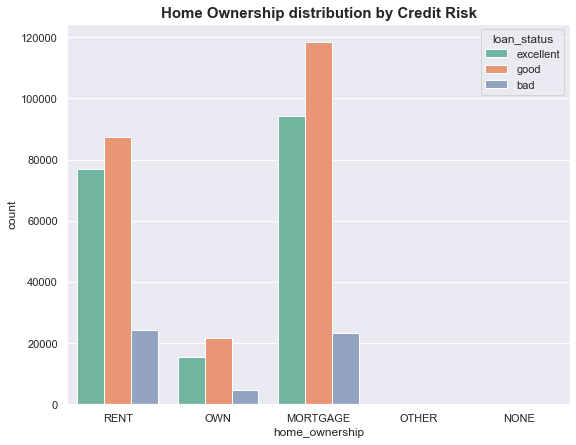

In [46]:
plt.figure(figsize=(9, 7))

sns.countplot(
    x= "home_ownership",
    hue = "loan_status",
    data= loan_df,
    hue_order=loan_status_order,
    palette='Set2'
)
plt.title("Home Ownership distribution by Credit Risk",
    loc="center",
    fontweight="bold",
    size=15
)
plt.show()

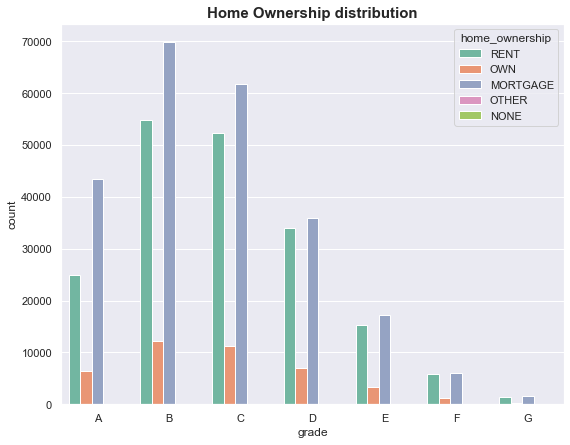

In [47]:
plt.figure(figsize=(9, 7))

sns.countplot(
    x= "grade",
    hue = "home_ownership",
    data= loan_df,
    order=grade_order,
    palette='Set2'
)
plt.title("Home Ownership distribution",
    loc="center",
    fontweight="bold",
    size=15
)
plt.show()

In [48]:
model_data = loan_df.copy()

### Encode Target

In [49]:
model_data["risk_flag"] = loan_df['loan_status'].replace({
    'excellent' : 2,
    'good' : 1,
    'bad' : 0
})

In [50]:
model_data.drop(["loan_status"], axis=1, inplace=True)

### Data Split

In [51]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(model_data, target = "risk_flag", 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42)

## Outlier Handling

In [52]:
X_train_join = pd.concat([X_train, y_train], axis = 1)

In [53]:
num_col = [col for col in model_data.columns.tolist() if col not in X_train.select_dtypes(include='object').columns.tolist() + ['risk_flag']]

In [54]:
def skewness(data) :
    skew = []
    for i in num_col:
        skew.append(data[i].skew())
    return skew

def outlier_ratio(data, data_info) :
    ratio = []
    for i in range(len(data_info)) :
        feature = data_info["feature"][i]
        if abs(data_info["skewness"][i]) <= 0.5 :
            LL, UL = limit_normal(data[feature])
            try : 
                result = data[feature][(data[feature] <= LL) | (data[feature] >= UL)].count() / len(data[feature])
            except : 
                result = 0
        else : 
            LL, UL = limit_skewed(data[feature])
            try : 
                result = data[feature][(data[feature] <= LL) | (data[feature] >= UL)].count() / len(data[feature])
            except : 
                result = 0
        ratio.append(round(result,6))
    return ratio

def limit_normal(data) :
    lower_limit = data.mean() - (3 * data.std())
    upper_limit = data.mean() + (3 * data.std())
    return lower_limit, upper_limit

def limit_skewed(data) : 
    Q1, Q3 = np.quantile(data, (0.25, 0.75))
    IQR = Q3 - Q1
    lower_limit = Q1 - (IQR * 1.5)
    upper_limit = Q3 + (IQR * 1.5)
    return lower_limit, upper_limit

def treatment_type(data, data_info) :
    treatment = []
    for i in range(len(data_info)) :
        ratio = data_info["outlier_ratio"][i]
        if ratio == 0:
            treatment.append('none')
        elif ratio <= 0.05:
            treatment.append('trim')
        elif ratio <= 0.15:
            treatment.append('cap')
        else :
            treatment.append('none')
    return treatment

In [55]:
outliers_info = pd.DataFrame({
    "feature" : num_col,
    "skewness" : skewness(X_train_join)
})

In [56]:
outliers_info["outlier_ratio"] = outlier_ratio(X_train_join, outliers_info)
outliers_info["treatment"] = treatment_type(X_train_join, outliers_info)

In [57]:
outliers_info

,feature,skewness,outlier_ratio,treatment
0,loan_amnt,0.731944,0.000000,none
1,funded_amnt,0.736001,0.000000,none
2,int_rate,0.334499,0.000000,none
3,installment,0.951611,0.025213,trim
4,annual_inc,24.564584,0.000000,none
5,dti,0.186561,0.000000,none
6,delinq_2yrs,5.371369,0.000000,none
7,inq_last_6mths,2.181584,0.000000,none
8,mths_since_last_delinq,0.464933,0.000177,trim
9,open_acc,1.167166,0.000000,none


In [58]:
# for normal distribution
normal_cap = Winsorizer(
    capping_method='gaussian',
    tail='both',
    fold=1.5,
    variables=outliers_info[(abs(outliers_info['skewness']) <= 0.5) & (outliers_info['treatment'] == 'cap')]['feature'].tolist(),
    missing_values='ignore'
)

# for skewed distribution
skewed_cap = Winsorizer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables=outliers_info[~(abs(outliers_info['skewness']) <= 0.5) & (outliers_info['treatment'] == 'cap')]['feature'].tolist(),
    missing_values='ignore'
)

# for normal distribution
normal_trim = OutlierTrimmer(
    capping_method='gaussian',
    tail='both',
    fold=3,
    variables=outliers_info[(abs(outliers_info['skewness']) <= 0.5) & (outliers_info['treatment'] == 'trim')]['feature'].tolist(),
    missing_values='ignore'
)

# for skewed distribution
skewed_trim = OutlierTrimmer(
    capping_method='iqr',
    tail='both',
    fold=3,
    variables=outliers_info[~(abs(outliers_info['skewness']) <= 0.5) & (outliers_info['treatment'] == 'trim')]['feature'].tolist(),
    missing_values='ignore'
)

In [59]:
# X_train_join = normal_cap.fit_transform(X_train_join)
X_train_join = skewed_cap.fit_transform(X_train_join)
X_train_join = normal_trim.fit_transform(X_train_join)
X_train_join = skewed_trim.fit_transform(X_train_join)

In [60]:
outliers_info["result"] = skewness(X_train_join)
outliers_info[outliers_info.treatment != "none"]

,feature,skewness,outlier_ratio,treatment,result
3,installment,0.951611,0.025213,trim,0.952507
8,mths_since_last_delinq,0.464933,0.000177,trim,0.440539
11,revol_bal,20.469531,0.048865,trim,1.306504
12,revol_util,-0.135387,0.000051,trim,-0.254771
14,out_prncp,1.590080,0.050350,cap,1.243087
15,total_pymnt,1.407346,0.040949,trim,1.319422
16,total_rec_prncp,1.445561,0.044415,trim,1.421843
17,total_rec_int,2.272172,0.066762,cap,1.065531
21,last_pymnt_amnt,2.556830,0.149975,cap,1.254436
29,mths_since_issue_d,1.719902,0.053610,cap,1.040866


## Missing Value

### Numerical

In [61]:
check_missing = X_train_join.select_dtypes(exclude='object').isnull().sum() * 100 / X_train_join.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

mths_since_last_delinq           53.506757
mths_since_next_pymnt_d          48.744761
tot_cur_bal                      14.989228
total_rev_hi_lim                 14.989228
tot_coll_amt                     14.989228
emp_length_int                    4.545193
mths_since_last_pymnt_d           0.082670
revol_util                        0.070351
collections_12_mths_ex_med        0.029838
mths_since_last_credit_pull_d     0.009307
mths_since_earliest_cr_line       0.006570
acc_now_delinq                    0.006570
delinq_2yrs                       0.006570
total_acc                         0.006570
pub_rec                           0.006570
open_acc                          0.006570
inq_last_6mths                    0.006570
annual_inc                        0.000821
dtype: float64

In [62]:
for i in check_missing[check_missing > 0].index.tolist() :
    for j in X_train_join["risk_flag"].unique() :
        X_train_join[i].fillna(X_train_join[X_train_join["risk_flag"] == j][i].median(), inplace=True)

### Categorical

In [63]:
check_missing = X_train_join.select_dtypes(include='object').isnull().sum() * 100 / loan_df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

Series([], dtype: float64)

#### Rebuild

In [64]:
X_train, y_train = X_train_join.drop(["risk_flag"], axis=1), X_train_join["risk_flag"]

## Feature Selection

In [65]:
corr_data = pd.concat([X_train, y_train], axis=1)

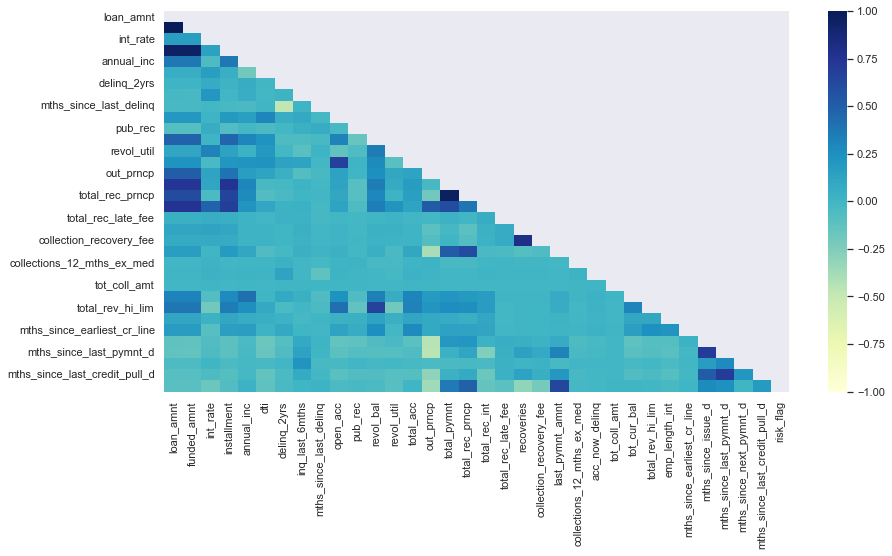

In [66]:
plt.figure(figsize=(14,7))
sns.heatmap(corr_data.corr(), cmap="YlGnBu", mask=np.triu(corr_data.corr()), vmin=-1, vmax=1)
plt.show()

In [67]:
corr_matrix = corr_data.corr().abs()
to_pick_hicorr = corr_matrix.unstack()["risk_flag"].sort_values(kind="quicksort", ascending=False)

In [68]:
to_pick_hicorr

risk_flag                        1.000000
last_pymnt_amnt                  0.636549
total_rec_prncp                  0.491657
out_prncp                        0.367177
total_pymnt                      0.359426
recoveries                       0.305182
mths_since_issue_d               0.279663
mths_since_last_pymnt_d          0.243002
collection_recovery_fee          0.205344
mths_since_last_credit_pull_d    0.181745
int_rate                         0.168011
total_rec_int                    0.141427
dti                              0.124120
total_rec_late_fee               0.104271
funded_amnt                      0.099623
loan_amnt                        0.098317
revol_util                       0.089939
installment                      0.069995
open_acc                         0.046829
revol_bal                        0.043314
delinq_2yrs                      0.038698
emp_length_int                   0.030562
pub_rec                          0.030346
annual_inc                       0

In [69]:
num_select = to_pick_hicorr[to_pick_hicorr >= 0.3].index.tolist()
num_select.remove("risk_flag")

In [70]:
num_select

['last_pymnt_amnt',
 'total_rec_prncp',
 'out_prncp',
 'total_pymnt',
 'recoveries']

### Categorical

In [71]:
cat_col = corr_data.select_dtypes(include='object').columns.tolist()

In [72]:
label = LabelEncoder()
data_encoded = pd.DataFrame() 

for i in cat_col :
    data_encoded[i]=label.fit_transform(corr_data[i])

In [73]:
data_encoded["risk_flag"] = corr_data["risk_flag"].reset_index(drop=True)

In [74]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    chi2 = stats.chi2_contingency(crosstab)[0]
    n = np.sum(crosstab)
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def cramers_results() :
    rows= []
    for var1 in data_encoded:
        col = []
        for var2 in data_encoded :
            cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
            col.append(round(cramers,2))
        rows.append(col)
    results = np.array(rows)
    return results

cramers_df = pd.DataFrame(cramers_results(), columns = data_encoded.columns, index =data_encoded.columns)

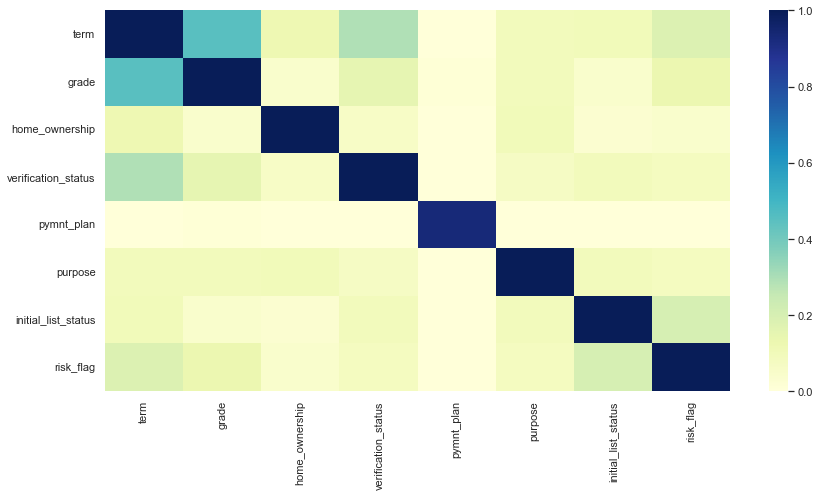

In [75]:
plt.figure(figsize=(14,7))
sns.heatmap(cramers_df, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

In [76]:
to_pick_hicorr = cramers_df["risk_flag"].sort_values(kind="quicksort", ascending=False)

In [77]:
to_pick_hicorr

risk_flag              1.00
initial_list_status    0.20
term                   0.18
grade                  0.13
verification_status    0.08
purpose                0.08
home_ownership         0.04
pymnt_plan             0.00
Name: risk_flag, dtype: float64

In [78]:
cat_select = to_pick_hicorr[to_pick_hicorr >= 0.1].index.tolist()
cat_select.remove("risk_flag")

In [79]:
cat_select

['initial_list_status', 'term', 'grade']

In [80]:
X_train = X_train[num_select + cat_select]
X_valid = X_valid[num_select + cat_select]
X_test = X_test[num_select + cat_select]

## Data Prep

#### PCA Analyze

In [81]:
pca_df = X_train.copy()

In [82]:
ohe = pd.get_dummies(pca_df[cat_select], drop_first=True)

In [83]:
transformer_std = StandardScaler()
pca_df[num_select] = transformer_std.fit_transform(pca_df[num_select])

In [84]:
pca_df = pd.concat([pca_df[num_select], ohe], axis=1)

In [85]:
pca = PCA(n_components = None)
graph_pca = pca.fit_transform(pca_df)

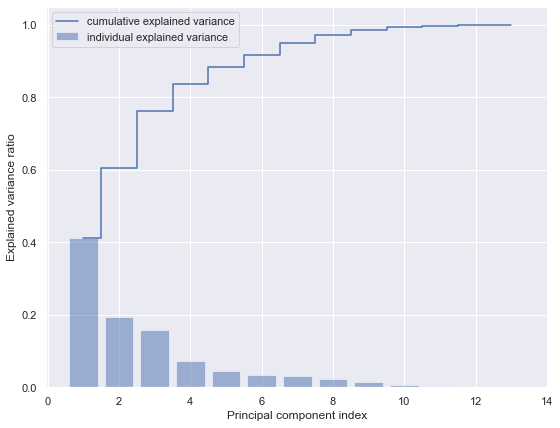

In [86]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

ax, fig = plt.subplots(1,1,figsize=(9, 7))
# Plot explained variances.
plt.bar(range(1, pca_df.shape[1]+1), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, pca_df.shape[1]+1), cum_var_exp, where='mid',
        label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

#### Missing Value Treatment Valid - Test

In [87]:
X_valid_join = pd.concat([X_valid, y_valid], axis=1).dropna(axis=0, how="any")
X_valid, y_valid = X_valid_join.drop(["risk_flag"], axis=1), X_valid_join["risk_flag"]
X_test_join = pd.concat([X_test, y_test], axis=1).dropna(axis=0, how="any")
X_test, y_test = X_test_join.drop(["risk_flag"], axis=1), X_test_join["risk_flag"]

### Pipeline

#### Transform

In [88]:
transformer_std = StandardScaler()
transformer_ohe = OneHotEncoder(drop="first")
pca = PCA(n_components=0.9, random_state=42)
oversample = SMOTETomek(random_state = 42, n_jobs= -1)
transformer_yeo = PowerTransformer(method ='yeo-johnson')

num_pipeline = Pipeline(
    steps=[
        ('power_transform', transformer_yeo),
        ('standardize', transformer_std)
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ('one_hot', transformer_ohe)
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', num_pipeline, num_select),
        ('categorical', cat_pipeline, cat_select)
    ]
)

## Models

In [89]:
clf_rf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', pca),
        ('smote', oversample),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs= -1))
    ]
)

clf_knn = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', pca),
        ('smote', oversample),
        ('classifier', KNeighborsClassifier(n_neighbors=3, n_jobs=-1))
    ]
)

clf_xgb = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', pca),
        ('smote', oversample),
        ('classifier', XGBClassifier(random_state=42, n_jobs=-1, verbosity=0))
    ]
)

clf_logreg = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', pca),
        ('smote', oversample),
        ('classifier', LogisticRegression(random_state=42, n_jobs=-1))
    ]
)

clf_dct = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', pca),
        ('smote', oversample),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]
)

### Analyze Models

In [94]:
def cm_matrix(pred, name) :
    target = list(reversed(loan_status_order))
    cm = confusion_matrix(list(y_valid), pred)
    cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_norm, 
        cmap="YlGnBu", 
        annot=True,
        xticklabels=target,
        yticklabels=target
    )
    plt.title(f"VAL - Normalized {name}",
        loc="center",
        fontweight="bold",
        size=15
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Random Forest Accuracy score :  96.6973
Random Forest F1 score :  96.6875
Random Forest Recall score :  96.6973
Random Forest Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      5121
           1       0.97      0.98      0.97     22742
           2       0.99      0.99      0.99     18765

    accuracy                           0.97     46628
   macro avg       0.94      0.94      0.94     46628
weighted avg       0.97      0.97      0.97     46628



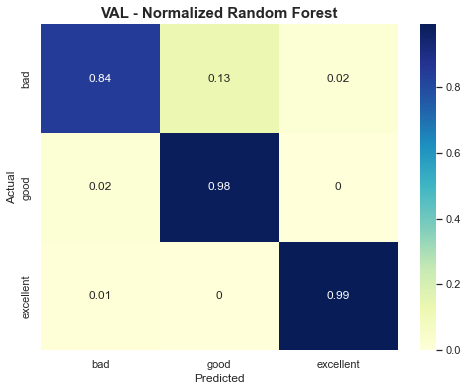


K-Nearest Neighbor Accuracy score :  95.1874
K-Nearest Neighbor F1 score :  95.2879
K-Nearest Neighbor Recall score :  95.1874
K-Nearest Neighbor Classification report : 
               precision    recall  f1-score   support

           0       0.76      0.83      0.79      5121
           1       0.97      0.96      0.96     22742
           2       0.99      0.98      0.99     18765

    accuracy                           0.95     46628
   macro avg       0.91      0.92      0.91     46628
weighted avg       0.95      0.95      0.95     46628



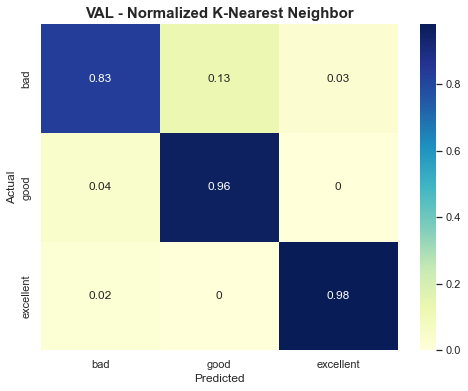


XGboost Accuracy score :  96.9739
XGboost F1 score :  96.9268
XGboost Recall score :  96.9739
XGboost Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      5121
           1       0.97      0.99      0.98     22742
           2       0.99      0.98      0.99     18765

    accuracy                           0.97     46628
   macro avg       0.95      0.93      0.94     46628
weighted avg       0.97      0.97      0.97     46628



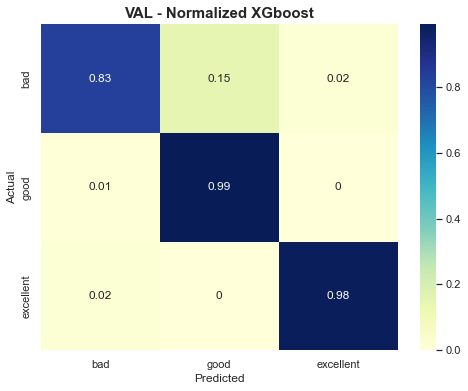


Logistic Regression Accuracy score :  94.6663
Logistic Regression F1 score :  94.5698
Logistic Regression Recall score :  94.6663
Logistic Regression Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.73      0.76      5121
           1       0.96      1.00      0.98     22742
           2       0.97      0.94      0.96     18765

    accuracy                           0.95     46628
   macro avg       0.91      0.89      0.90     46628
weighted avg       0.95      0.95      0.95     46628



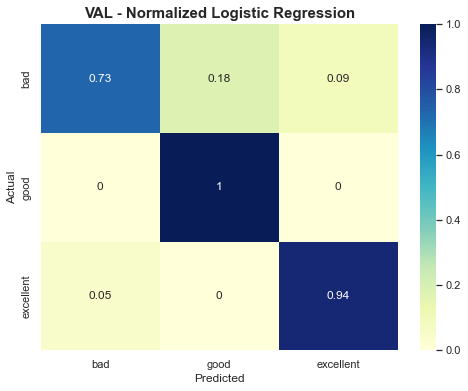


Decision Tree Accuracy score :  94.143
Decision Tree F1 score :  94.3735
Decision Tree Recall score :  94.143
Decision Tree Classification report : 
               precision    recall  f1-score   support

           0       0.69      0.84      0.76      5121
           1       0.97      0.94      0.96     22742
           2       0.99      0.97      0.98     18765

    accuracy                           0.94     46628
   macro avg       0.88      0.92      0.90     46628
weighted avg       0.95      0.94      0.94     46628



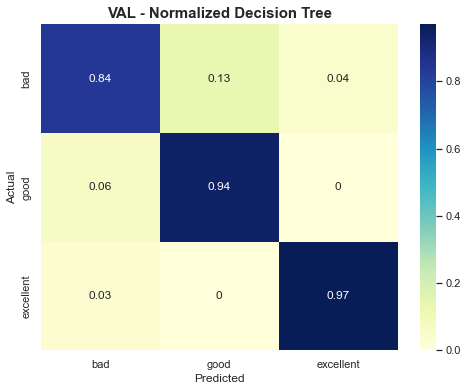

In [95]:
classifier = [clf_rf, clf_knn, clf_xgb, clf_logreg, clf_dct]
classifier_name = ["Random Forest", "K-Nearest Neighbor", "XGboost", "Logistic Regression", "Decision Tree"]

for i,j in zip(classifier, classifier_name) :
    i.fit(X_train, y_train)
    val_pred = i.predict(X_valid)
    f1 = f1_score(list(y_valid), val_pred, average="weighted")
    recall = recall_score(list(y_valid), val_pred, average="weighted")
    accuracy = accuracy_score(list(y_valid), val_pred)
    print(f"{j} Accuracy score : ", round(accuracy * 100, 4))
    print(f"{j} F1 score : ", round(f1 * 100, 4))
    print(f"{j} Recall score : ",round(recall * 100, 4))
    print(f"{j} Classification report : \n", classification_report(list(y_valid), val_pred))
    cm_matrix(val_pred, j)
    print("=========================================================================\n")

In [207]:
# import pickle
# with open(os.path.join("model", "model_credit_risk_idx.pkl"),'wb') as f:
#     pickle.dump(clf_xgb,f)

### Test Data

In [97]:
test_pred = clf_xgb.predict(X_test)

In [105]:
def flag_inverse(target) :
    inverse = []
    for i in target :
        if i == 0 :
            inverse.append("bad")
        elif i == 1 :
            inverse.append("good")
        else :
            inverse.append("excellent")
    return inverse

In [106]:
test_df = pd.DataFrame({
    "Actual" : flag_inverse(y_test),
    "Predicted" : flag_inverse(test_pred)
})

In [126]:
test_df.sample(10, random_state=42)

,Actual,Predicted
24663,good,good
7478,good,good
44905,good,good
16796,good,good
9951,excellent,excellent
23719,good,good
14168,bad,bad
40518,good,good
15917,good,good
4785,good,good


In [132]:
print("Selected features : ", num_select + cat_select)

Selected features :  ['last_pymnt_amnt', 'total_rec_prncp', 'out_prncp', 'total_pymnt', 'recoveries', 'initial_list_status', 'term', 'grade']


In [135]:
!jupyter-nbconvert --to PDFviaHTML credit_risk_v5.ipynb

[NbConvertApp] Converting notebook credit_risk_v5.ipynb to PDFviaHTML
[NbConvertApp] Writing 1101388 bytes to credit_risk_v5.pdf


In [168]:
X_test[:1]

,last_pymnt_amnt,total_rec_prncp,out_prncp,total_pymnt,recoveries,initial_list_status,term,grade
130561,80.09,7500.0,0.0,9048.750048,0.0,f,36,C


In [200]:
coba = pd.DataFrame(X_test.sample().values, columns=num_select + cat_select)

In [201]:
coba

,last_pymnt_amnt,total_rec_prncp,out_prncp,total_pymnt,recoveries,initial_list_status,term,grade
0,17969.88,35000.0,0.0,54934.1192,0.0,f,60,F
1,1080.54,12749.01,22250.99,15107.17,0.0,f,36,A
2,1115.96,12000.0,0.0,13259.60842,0.0,f,36,A
3,427.78,3652.55,8347.45,5549.81,0.0,f,36,D
4,17155.69,17000.0,0.0,17155.69167,0.0,f,60,B
5,505.34,9785.11,5214.89,12669.74,0.0,f,36,B
6,814.03,8084.24,26915.76,14652.54,0.0,f,60,C
7,458.22,4179.93,19820.07,7749.17,0.0,w,60,C
8,779.84,9723.21,15276.79,11670.9,0.0,f,36,A
9,415.0,3015.03,0.0,9652.01,2211.81,f,60,E


In [206]:
clf_xgb.predict(coba)

array([2, 1, 2, 1, 2, 1, 1, 1, 1, 0], dtype=int64)